In [1]:
# !pip install tab2img

## import libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout 
from tensorflow.keras.layers import BatchNormalization 
from tensorflow.keras.utils import to_categorical

# from tab2img.converter import Tab2Img
from xgboost import XGBClassifier

# **Read CSV files**

In [3]:
# read file
df  = pd.read_csv("dataset/dataset.csv")
df.head()

,Category of Trade,Volume/ Amount,Volume Type,Load Port,Discharge Port,Dangerous Goods,Organisation
0,7,"26,726",1,27,34,2,73
1,5,"2,600",1,44,54,2,69
2,7,"10,710",1,8,0,2,12
3,7,"21,611",1,8,40,2,12
4,7,"5,139",1,6,0,2,12


# **Seperate features and target**

In [4]:
# seperate features and target column
features = ["Category of Trade", "Volume Type", "Load Port", "Discharge Port", "Dangerous Goods"]
target = "Organisation"

# copy the feqatures and class dataframe in X and y variable
X = df[features]
y = df[target]

# **Scale features and train test split**

In [5]:
# scalling feature value between the range of 0-1
ss = StandardScaler()
X = ss.fit_transform(X)


## customize functions

In [6]:
#list of evaluation scores
evalution_scores = []

# save saller
pkl_file = open('others/target_encoder.pkl', 'rb')
le_target = pickle.load(pkl_file) 

# function for getting class labels via class integar using label encoder
def get_classes(y_test):
    y_test = y_test.unique()
    print(len(y_test))
    return le_target.inverse_transform(y_test)

# get unique classes in test set
def get_str_classes(y_test):
    y_test = y_test.unique()
    return [str(int) for int in y_test]

# split dataset in training and testing set 
def get_train_test_split():
    return train_test_split(X, y, test_size=0.2, random_state=42)


# split data into train, test and validation set with splitted feature and class
def get_train_test_val_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.22, random_state=2)
    return X_train, X_test, X_val, y_train, y_test, y_val

# split data into train, test and validation set with joined feature and class
def get_train_test_val_split_df():
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.25, random_state=2)
    return train, test, val


# compute the accuracy using true and predicted labels
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = correct_predictions/len(y_true)
    return accuracy


# compute other evaluation measures and print
def make_predictions(y_test, y_pred):
    accuracy=accuracy_score(y_test, y_pred)
    P, R, F, S = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    
    accuracy = "{:.4f}".format(accuracy)
    P = "{:.4f}".format(P)
    R = "{:.4f}".format(R)
    F = "{:.4f}".format(F)

    print("Accuracy Score :", accuracy)
    print("=======================\n")

    print("Precision Score :", P)
    print("========================\n")

    print("Recall Score :", R)
    print("=====================\n")

    print("F1 Score :", F)
    print("=================\n")

    return accuracy, P, R, F


# convert the vector input into matrix for deep leaning model
def DL_preprocessing(train, target):
    target = target.to_numpy()
    model = Tab2Img()
    images = model.fit_transform(train, target)
    
    size = (200, 200)
    reshaped_images = []
    for img in images:
        img = np.resize(img, (img.shape[0], img.shape[1], 3))
        reshaped_images.append(tf.keras.preprocessing.image.smart_resize(
            img, size, interpolation='bilinear'
        ))
    reshaped_images = np.array(reshaped_images)
    target = tf.keras.utils.to_categorical(target, 81)
    return reshaped_images, target

# plot graph of accuracy and loss using history object
def plot_graph(history):
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# **Machine Learning Models**
## **Random Forest**

In [7]:
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


<BarContainer object of 5 artists>

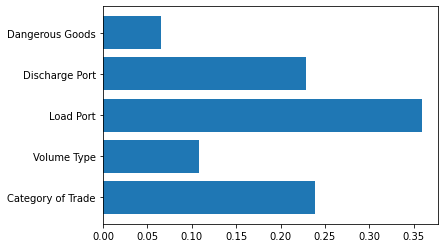

In [8]:
# model initialization
clf = RandomForestClassifier(n_estimators=50, max_depth=11, random_state=0)
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [9]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["Random Forest", Acc, P, R, F])

Accuracy Score : 0.7774

Precision Score : 0.7594

Recall Score : 0.7774

F1 Score : 0.7433



## **XG Boost**

In [10]:
# train test split
X_train, X_test, y_train, y_test = get_train_test_split()
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")


shape of training features : (17271, 5)

 shape of training labels : (17271,)

 shape of testing features : (4318, 5)

 shape of testing labels : (4318,)


<BarContainer object of 5 artists>

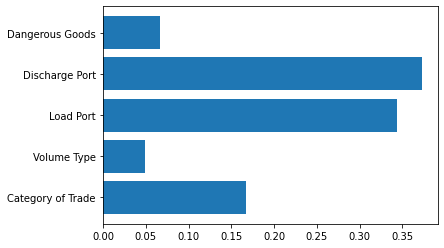

In [11]:
# model initialization
clf = XGBClassifier(learning_rate=0.2, n_estimators=10, max_depth=5)
# model training
clf = clf.fit(X_train, y_train)
plt.barh(features, clf.feature_importances_)

In [12]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["XG Boost", Acc, P, R, F])

Accuracy Score : 0.7730

Precision Score : 0.7700

Recall Score : 0.7730

F1 Score : 0.7447



## **SVM Model**

In [13]:
# model initialization
clf = svm.SVC(kernel='rbf', gamma=1, C=0.5)
# model training
clf = clf.fit(X_train, y_train)
# plt.barh(features, clf.coef_)

In [14]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["SVM", Acc, P, R, F])

Accuracy Score : 0.7186

Precision Score : 0.6930

Recall Score : 0.7186

F1 Score : 0.6819



## **KNN Model**

In [15]:
from sklearn.neighbors import KNeighborsClassifier
# model initialization
clf = KNeighborsClassifier(n_neighbors=6, p=1, leaf_size=3)
# model training
clf = clf.fit(X_train, y_train)
# plt.barh(features, clf.coef_)

In [16]:
# model predictions
y_pred = clf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["KNN", Acc, P, R, F])

Accuracy Score : 0.7754

Precision Score : 0.7927

Recall Score : 0.7754

F1 Score : 0.7523



## Customize Model 1

In [17]:
X_train, X_test, X_val, y_train, y_test, y_val = get_train_test_val_split(X, y)
print("\nshape of training features :", X_train.shape)
print("=======================================")
print("\n shape of training labels :", y_train.shape)
print("====================================")
print("\n shape of testing features :", X_test.shape)
print("======================================")
print("\n shape of testing labels :", y_test.shape)
print("==================================")
print("\n shape of validation features :", X_val.shape)
print("========================================")
print("\n shape of validation labels :", y_val.shape)
print("=====================================")


shape of training features : (15155, 5)

 shape of training labels : (15155,)

 shape of testing features : (2159, 5)

 shape of testing labels : (2159,)

 shape of validation features : (4275, 5)

 shape of validation labels : (4275,)


In [18]:
# deep learning model initialization
model = tf.keras.models.Sequential()  
model.add(Dense(1000,input_dim=5,activation='relu'))
model.add(Dense(500,activation='relu'))
model.add(Dense(300,activation='relu'))
model.add(Dense(150,activation='relu'))
model.add(Dense(75,activation='relu'))
model.add(Dense(30,activation='relu'))
model.add(Dense(15,activation='relu'))
model.add(Dropout(0.5))

RF_X_train = model.predict(X_train)
RF_X_test = model.predict(X_test)

In [19]:
# model initialization
clf = RandomForestClassifier(n_estimators=20, max_depth=None, random_state=1)
# model training
clf = clf.fit(RF_X_train, y_train)

In [20]:
# model predictions
y_pred = clf.predict(RF_X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["customize 1", Acc, P, R, F])

Accuracy Score : 0.7934

Precision Score : 0.8049

Recall Score : 0.7934

F1 Score : 0.7705



In [2]:
from eli5.sklearn import PermutationImportance

ModuleNotFoundError: No module named 'eli5'

In [4]:
!pip install eli5

  Using cached eli5-0.13.0.tar.gz (216 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\abdul\\.conda\\envs\\tf2x\\lib\\site-packages\\numpy-1.21.5.dist-info\\METADATA'



## Customize 2

In [21]:
from sklearn.ensemble import VotingClassifier

clf1 = RandomForestClassifier(random_state=1)
clf2 = XGBClassifier(learning_rate=0.2, n_estimators=100, max_depth=5)
clf3 = KNeighborsClassifier()

eclf = VotingClassifier(estimators=[('rf', clf1), ('cgb', clf2), ('knn', clf3)], voting='soft', weights=[1, 1, 1])
eclf = eclf.fit(X_train, y_train)

In [22]:
# model predictions
y_pred = eclf.predict(X_test)
# evaluate results
Acc, P, R, F = make_predictions(y_test, y_pred)
evalution_scores.append(["customize 2", Acc, P, R, F])

Accuracy Score : 0.7962

Precision Score : 0.7827

Recall Score : 0.7962

F1 Score : 0.7673



In [23]:
evaluation_df = pd.DataFrame(evalution_scores, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
evaluation_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.7774,0.7594,0.7774,0.7433
1,XG Boost,0.7730,0.7700,0.7730,0.7447
2,SVM,0.7186,0.6930,0.7186,0.6819
3,KNN,0.7754,0.7927,0.7754,0.7523
4,customize 1,0.7934,0.8049,0.7934,0.7705
5,customize 2,0.7962,0.7827,0.7962,0.7673


## predict 4 Best Service Providers

In [24]:
# load and return dictionary of label encoders
def get_label_encoders():
    columns = ["Category of Trade", "Volume Type",
               "Load Port", "Discharge Port", "Dangerous Goods"]

    le_dict = open("others/le_dict.pickle",'rb')
    le_dict = pickle.load(le_dict)
    
    le_target = open("others/target_encoder.pkl",'rb')
    le_target = pickle.load(le_target)
    return le_dict, le_target, columns

# convert the integral value of class into its label
def tranform_label(le_dict, le_dict_name, val):
    return le_dict[le_dict_name].transform([val])[0]

# display the best four service providers on screen
def display_output(le_target, indices):
    print("\nName of theBest 4 Service Providers :")
    print("====================================\n")
    for idx, indice in enumerate(indices):
        SP = le_target.inverse_transform([indice])
        print(idx, "--> ", SP[0], "\n")
    print("\n")

In [25]:
# sample 
feature_list = ["Petroleum", "MT", "Geelong", "Kwinana", "No"]

# list for appending encoded values of sample
le_features = []
# get label encoders dictionary
le_dict, le_target, columns = get_label_encoders()

# convert string value into numerical bvalues using label encoders
for idx, val in enumerate(feature_list):
    le_dict_name = columns[idx]
    value = tranform_label(le_dict, le_dict_name, val) if le_dict_name in le_dict else int(val)
    le_features.append(value)

noramilzed_features = ss.transform(np.array(le_features).reshape(1, -1)) #normalized values
result = eclf.predict_proba(noramilzed_features) # predict normalized sample using trained model

In [26]:
print("\nprobability of all Classes")
print("==========================\n")
print(result[0])


probability of all Classes

[2.06325882e-05 2.38595734e-06 2.42513291e-06 2.82372366e-06
 2.94014808e-06 2.72003520e-06 1.92779711e-06 1.74783176e-01
 6.34536697e-03 3.59477387e-06 1.14344846e-04 2.38198557e-06
 1.14284563e-01 1.67288939e-06 1.83412673e-06 1.35873549e-05
 2.97862522e-05 4.88978677e-05 1.26151849e-06 1.07593172e-01
 4.10380259e-06 2.67070088e-06 2.50367111e-06 2.72921534e-06
 1.82471770e-06 2.96510734e-06 4.22275601e-06 6.36918836e-06
 3.87916380e-04 3.08348262e-06 4.84067809e-03 8.80816697e-06
 1.43223200e-04 2.31182712e-05 1.03717836e-06 4.66478681e-06
 1.85054205e-06 2.81733028e-04 6.35505118e-06 2.17747720e-06
 1.44875670e-06 2.82444550e-06 6.29829992e-06 7.02366379e-04
 1.76742130e-05 1.39684516e-06 2.13125022e-04 6.69168487e-05
 8.34524447e-06 2.19551415e-06 1.84778849e-05 6.87869760e-05
 9.18573339e-06 3.37880071e-06 1.75316624e-06 8.59357594e-07
 2.11360521e-06 4.80625780e-06 2.58967793e-06 3.04247684e-06
 2.95535525e-05 1.18177339e-06 2.89824237e-05 2.60922237

In [27]:
print("\nprobability of all Classes in sorting order")
print("===========================================\n")
print((-result[0]).argsort())


probability of all Classes in sorting order

[73  7 12 19 79 74  8 30 75 43 28 37 46 32 10 51 47 17 16 60 62 66 33  0
 50 44 15 78 77 52 31 48 27 38 69 42 57 35 26 20 68  9 67 53 29 59 25  4
 80 41  3 23  5 21 76 63 58 22  2  1 11 49 39 56  6 71 36 14 24 54 13 72
 65 40 45 18 70 61 34 64 55]


In [28]:
# select the first four indices
n = 4
indices = (-result[0]).argsort()[:n]
print(indices)

[73  7 12 19]


In [29]:
# convert the class integar into its label value using Label Encoder
display_output(le_target, indices)


Name of theBest 4 Service Providers :

0 -->  Viva Energy Australia Ltd 

1 -->  Ampol Singapore Trading Pte Ltd 

2 -->  BP Australia Pty Ltd 

3 -->  Caltex Australia Petroleum Pty Ltd 



